In [20]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import layers, models
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input

In [21]:
dataset_path = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"

list_name = []

for dir in os.listdir(dataset_path):
    if dir != "classes.json":
        list_name.append(dir)

list_name = sorted(list_name)
     

In [22]:
def loadImg(dataset_path, dirTile):
    input_img, mask_img = [], []
    dir_path = os.path.join(dataset_path, dirTile)

    inpDir, maskDir = os.listdir(dir_path)
    imgDirs = sorted(os.listdir(os.path.join(dir_path, inpDir)))
    mask_imgDirs = sorted(os.listdir(os.path.join(dir_path, maskDir)))

    for imgDir in imgDirs:
        imgPath = os.path.join(dir_path, inpDir, imgDir)
        img = load_img(imgPath, target_size=(224, 224))
        img = tf.convert_to_tensor(img, dtype=tf.float32) / 255.0
        input_img.append(img)

    for mask_imgDir in mask_imgDirs:
        maskPath = os.path.join(dir_path, maskDir, mask_imgDir)
        mask = load_img(maskPath, target_size=(224, 224))
        mask = tf.convert_to_tensor(mask, dtype=tf.float32) / 255.0
        mask_img.append(mask)

    return input_img, mask_img

In [24]:
def loadData(dataset_path, listDir):
    imgs_data, masks_data = [], []

    for dirTile in list_name:
        input_imgs, mask_imgs = loadImg(dataset_path, dirTile)

        imgs_data.extend(input_imgs)
        masks_data.extend(mask_imgs)

    return imgs_data, masks_data

In [25]:

input_imgs, mask_imgs = loadData(dataset_path, list_name)

In [26]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_masks, test_masks = train_test_split(input_imgs, mask_imgs,test_size = 0.2,
shuffle = True,random_state = 42)

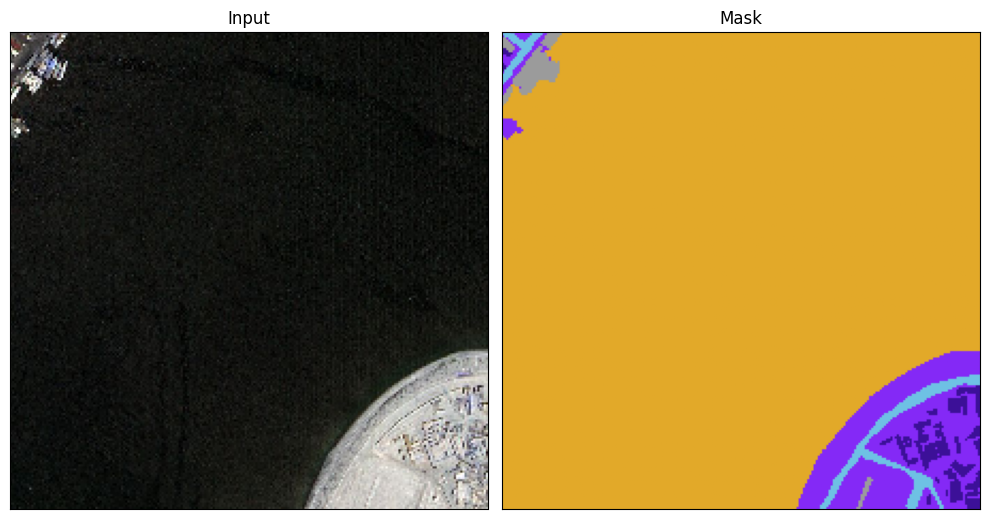

In [ ]:
plt.figure(figsize=(10, 8))

# Change the index here to display a different image
index = 50  # Change this value to select a different image

# Input image
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(train_imgs[index])  # Update to the new index
plt.xticks([])
plt.yticks([])
plt.grid(True)

# Mask image
plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(train_masks[index])  # Update to the new index
plt.xticks([])
plt.yticks([])
plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
train_data = np.array(list(zip(train_imgs, train_masks)))
test_data = np.array(list(zip(test_imgs, test_masks)))

In [29]:
from tensorflow.keras.layers import Add, Activation, Multiply, Conv2D

def attention_gate(x, g, filters):
    theta_x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(filters, kernel_size=1, strides=1, padding='same')(g)
    add = Add()([theta_x, phi_g])
    act = Activation('relu')(add)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(act)
    sigmoid = Activation('sigmoid')(psi)
    attention = Multiply()([x, sigmoid])

    return attention

In [30]:
def Conv(x, dropout, filters):
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(dropout)(x)
    pool = MaxPooling2D(pool_size=(2, 2))(x)
    return x, pool


def UpSample(x, skip_connect, dropout, filters):
    x = UpSampling2D(size=(2, 2))(x)
    attention = attention_gate(skip_connect, x, filters)
    x = Concatenate(axis=-1)([attention, x])
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    return x

In [32]:
def UNet(x, dropout, conv=[32, 64, 128, 256, 512]):
    # Encoder
    conv1, pool1 = Conv(x, dropout, conv[0])
    conv2, pool2 = Conv(pool1, dropout, conv[1])
    conv3, pool3 = Conv(pool2, dropout, conv[2])
    conv4, pool4 = Conv(pool3, dropout, conv[3])

    # Bottleneck
    conv5 = Conv2D(filters=conv[4], kernel_size=3, padding='same', activation='relu')(pool4)
    conv5 = Dropout(dropout)(conv5)
    conv5 = BatchNormalization()(conv5)

    # Decoder with attention
    conv6 = UpSample(conv5, conv4, dropout, conv[4])
    conv7 = UpSample(conv6, conv3, dropout, conv[3])
    conv8 = UpSample(conv7, conv2, dropout, conv[2])
    conv9 = UpSample(conv8, conv1, dropout, conv[1])

    # Output
    result = Conv2D(filters=3, kernel_size=1, padding='same', activation='sigmoid')(conv9)
    return result


In [33]:
# Input layer and model creation
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Add, Multiply, UpSampling2D, Concatenate, Activation
from tensorflow.keras.models import Model
input = Input(shape=(224, 224, 3))
output = UNet(input, dropout=0.1)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 224, 224, 32)   │            128 │ conv2d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 224, 224, 32)   │          9,248 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 224, 224, 32)   │              0 │ conv2d_31[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 112, 112, 32)   │              0 │ dropout_9[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 112, 112, 64)   │            256 │ conv2d_32[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 112, 112, 64)   │              0 │ conv2d_33[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 56, 56, 64)     │              0 │ dropout_10[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 56, 56, 128)    │            512 │ conv2d_34[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 56, 56, 128)    │              0 │ conv2d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 28, 28, 128)    │              0 │ dropout_11[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Trainable params: 11,577,319 (44.16 MB)

 Non-trainable params: 3,904 (15.25 KB)

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
     
history = model.fit(np.array(train_imgs), np.array(train_masks), batch_size = 8,epochs = 5,validation_data = (np.array(test_imgs), np.array(test_masks)))
     


Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 153s 17s/step - accuracy: 0.3294 - loss: 0.7766 - val_accuracy: 0.7098 - val_loss: 2.4588
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 138s 17s/step - accuracy: 0.8558 - loss: 0.5736 - val_accuracy: 0.7066 - val_loss: 15.6737
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 141s 17s/step - accuracy: 0.8603 - loss: 0.5650 - val_accuracy: 0.6697 - val_loss: 6.7975
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 137s 17s/step - accuracy: 0.8531 - loss: 0.5672 - val_accuracy: 0.6211 - val_loss: 9.7057
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 137s 17s/step - accuracy: 0.8350 - loss: 0.5743 - val_accuracy: 0.6808 - val_loss: 6.6461


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


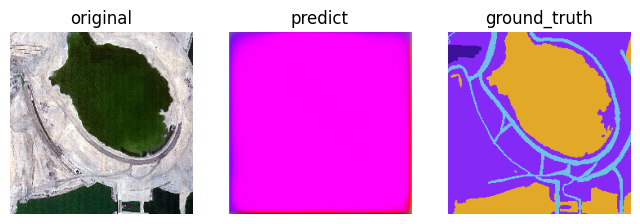

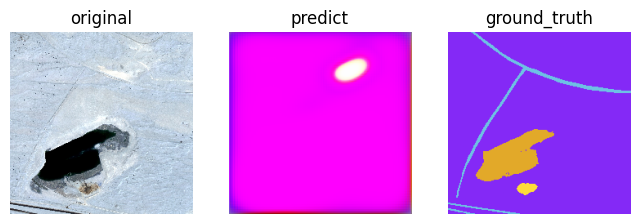

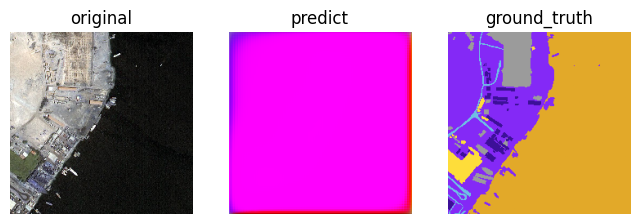

In [35]:
images_predict = model.predict(np.array(test_imgs))
def show_result(id):
    fig, ax = plt.subplots(1, 3, figsize = (8, 5))

    ax[0].set_title('original')
    ax[0].imshow(test_imgs[id])
    ax[0].axis("off")

    ax[1].set_title('predict')
    ax[1].imshow(images_predict[id])
    ax[1].axis("off")

    ax[2].set_title('ground_truth')
    ax[2].imshow(test_masks[id])
    ax[2].axis("off")

for id in range(3):
    show_result(id)

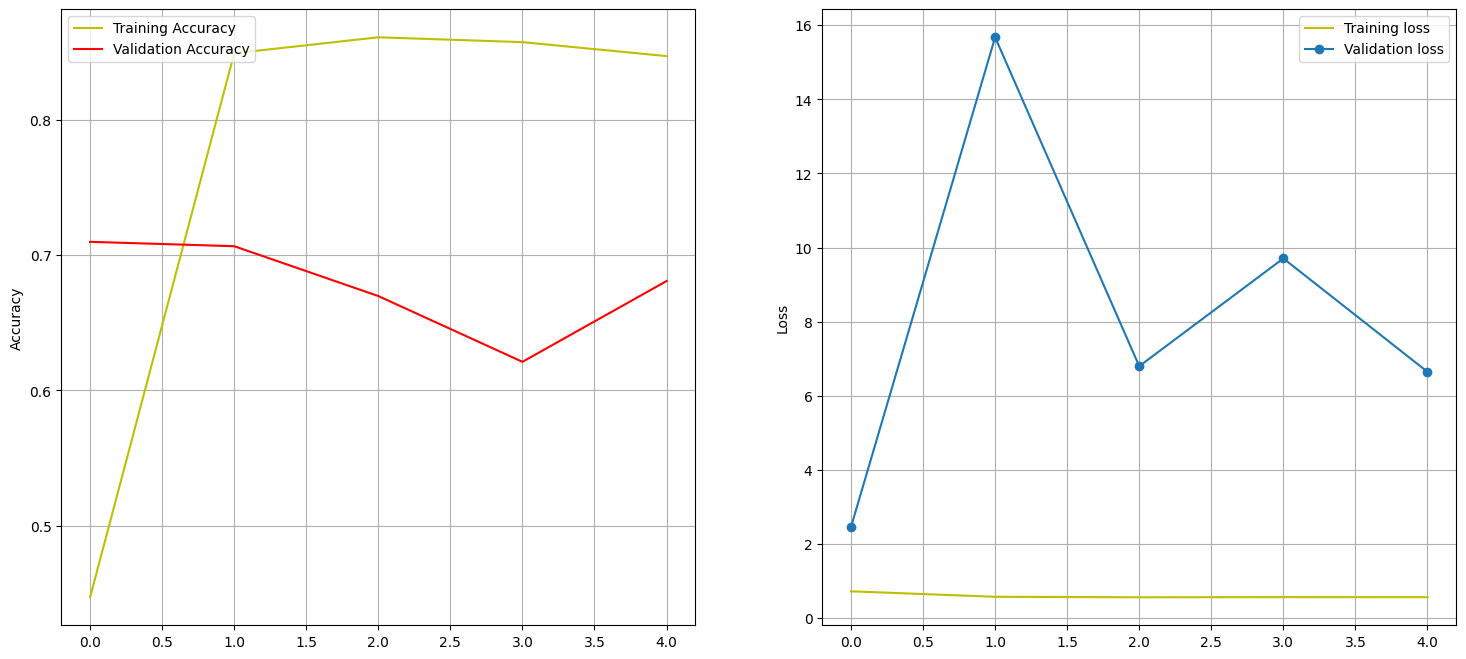

In [43]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'y-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label = 'Validation Accuracy')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'y-', label='Training loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation loss')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()